# Mesuring steam satisfaction and price prediction

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from data.steam import Steam as st
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, learning_curve
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import datetime

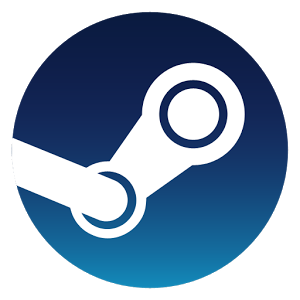

Steam is a video game digital distribution service and storefront developed by Valve Corporation. It was launched as a software client in September 2003 to provide game updates automatically for Valve's games, and expanded to distributing third-party titles in late 2005.

https://moldstud.com/articles/p-data-science-in-the-gaming-industry-trends-and-innovations#:~:text=retention%20and%20engagement.-,2.,fraud%2C%20and%20deliver%20tailored%20content.

Data scientists use statistical modeling and machine learning algorithms to predict player churn, identify potential fraud and cheating, and anticipate player preferences.
This helps in devising appropriate strategies to retain players, prevent fraud, and deliver tailored content.

In [3]:
games_df = st.Steam().get_three_dataset_game_price()

Completed:..............................|██████████████████████████████████████████████████|


In [4]:
games_df = games_df[games_df['Peak CCU'] > 0]
games_df.head()

,app_id,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,review_score,review_votes,price
3,22670,Alien Breed 3: Descent,2010-11-17,200000 - 500000,3,0,9.99,0,Alien Breed™ 3: Descent is the final explosive...,"['English', 'French', 'German', 'Italian', 'Ja...",...,24,0,Team17 Digital Ltd,Team17 Digital Ltd,"Single-player,Multi-player,Co-op,Steam Achieve...",Action,"Action,Shooter,Sci-fi,Aliens,Third Person,Isom...",0.309091,0.127273,NaN
4,346560,Hero of the Kingdom II,2015-02-20,100000 - 200000,5,0,7.99,0,Sail to the farthest islands to save your sist...,"['English', 'French', 'German', 'Spanish - Spa...",...,303,0,Lonely Troops,Lonely Troops,"Single-player,Steam Achievements,Steam Trading...","Adventure,Casual,Indie,RPG","Adventure,Casual,Point & Click,RPG,Indie,Isome...",0.857143,0.116883,NaN
6,434030,Aerofly FS 2 Flight Simulator,2017-11-20,100000 - 200000,19,0,37.49,23,Aerofly FS 2 lets you explore the world of fly...,"['English', 'German', 'French']",...,127,0,IPACS,IPACS,"Single-player,Partial Controller Support","Action,Indie,Racing,Simulation","Flight,Simulation,VR,Racing,Physics,Open World...",0.557196,0.284133,NaN
7,42500,DogFighter,2010-06-14,100000 - 200000,1,0,0.99,0,"DogFighter is a fast paced, arcade aerial comb...",['English'],...,1108,0,Dark Water Studios Ltd,Instinct Software Ltd.,"Single-player,Multi-player,Co-op,Steam Achieve...","Action,Indie","Action,Indie,Flight,Arcade,Multiplayer,Singlep...",0.215311,0.196172,NaN
8,262150,Vanguard Princess,2014-03-03,200000 - 500000,1,0,2.49,7,Government experiments on a young girl trigger...,['English'],...,244,0,Tomoaki Sugeno,eigoMANGA,"Single-player,Multi-player,PvP,Shared/Split Sc...","Action,Casual,Indie","Anime,Fighting,2D Fighter,Indie,Female Protago...",0.337413,0.170455,NaN


In [6]:
games_df.sort_values(['review_score'], inplace= True)

In [170]:
# scale features
from sklearn.preprocessing import MinMaxScaler, Normalizer

sample_for_test = games_df.sample(4000).copy()

X = sample_for_test[['review_score']]

#scaler = MinMaxScaler()
#scaler.fit(X)
#X = scaler.transform(X)

# scale the Peak CCU

y = np.log(sample_for_test['Peak CCU'])



In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)

X_train.shape, y_train.shape

((2800, 1), (2800,))

In [182]:
# Using tensor flow model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


def initialize_model():
    
    model = Sequential()
    opt_adam = Adam(learning_rate = 0.001)
    
    model.add(layers.Dense(20, activation='tanh', input_dim=1))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
                loss = 'mse',
                optimizer = opt_adam,
                metrics = 'mae'
    )
    
    return model


In [183]:
base_line = abs(y_test - y_train.mean()).mean()
base_line

1.6703324740382206

In [184]:
model = initialize_model()
model.summary()



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 20)                40        
                                                                 
 dense_60 (Dense)            (None, 1)                 21        
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [185]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 20, restore_best_weights=True)

history = model.fit(X_train, 
          y_train, 
          batch_size=16, 
          epochs=1000, 
          validation_split= 0.3,
          callbacks=[es])


Epoch 1/1000
123/123 [==============================] - 1s 7ms/step - loss: 7.2926 - mae: 1.8796 - val_loss: 5.3701 - val_mae: 1.6226
Epoch 2/1000
123/123 [==============================] - 1s 6ms/step - loss: 4.8216 - mae: 1.6262 - val_loss: 4.6669 - val_mae: 1.6412
Epoch 3/1000
123/123 [==============================] - 1s 6ms/step - loss: 4.5230 - mae: 1.6569 - val_loss: 4.6618 - val_mae: 1.6690
Epoch 4/1000
123/123 [==============================] - 1s 6ms/step - loss: 4.5131 - mae: 1.6648 - val_loss: 4.6665 - val_mae: 1.6813
Epoch 5/1000
123/123 [==============================] - 1s 6ms/step - loss: 4.5114 - mae: 1.6735 - val_loss: 4.6537 - val_mae: 1.6768
Epoch 6/1000
123/123 [==============================] - 1s 7ms/step - loss: 4.5062 - mae: 1.6688 - val_loss: 4.6576 - val_mae: 1.6846
Epoch 7/1000
123/123 [==============================] - 1s 6ms/step - loss: 4.5035 - mae: 1.6710 - val_loss: 4.6423 - val_mae: 1.6754
Epoch 8/1000
123/123 [==============================] - 1s 6ms

In [176]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

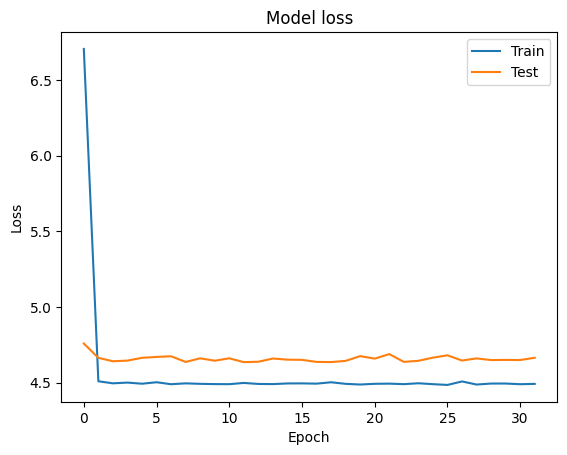

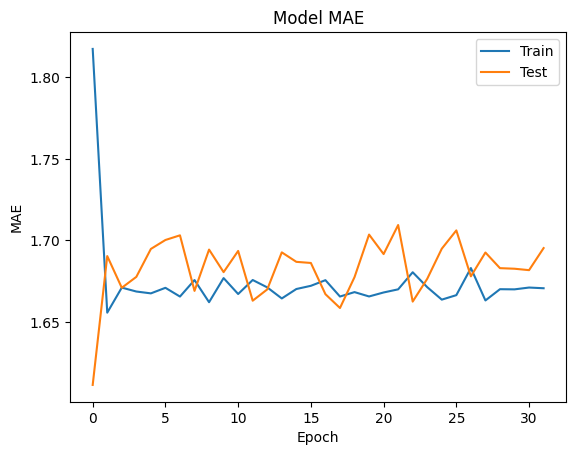

In [177]:
plot_loss_accuracy(history)

In [127]:
model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 4ms/step - loss: 4.2952 - mae: 1.6259


[4.295156002044678, 1.6258739233016968]

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
reg = LinearRegression()

model = cross_validate(reg, X_train, y_train, cv = 7)
model['test_score'].mean()

0.030082747604865907

## Popular games vs rating

In [ ]:
games_top = st.Steam().get_top_games()
games_top.head()

In [ ]:


games_top = games_top[games_top['followers'] > 0]
sample = games_top.sample(1000)
X = sorted(sample[['rating']])
y = sorted(sample['followers'])
sns.scatterplot(x=sample['rating'], y=sample['max peak'], alpha = 0.2)
plt.ylim(0,15000)
plt.show()

# TODO check joblib memory
# had 0.20579852251219205 with polynomial and transformed log outside pipeline
import numpy as np
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

sample = games_top.sample(1000)

X_train, X_test, y_train, y_test = train_test_split(sample[['rating']], sample['max peak'], 
                                                 test_size=0.33, 
                                                 random_state=42)


transformer = FunctionTransformer(lambda y: np.log(y))

pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Lasso(alpha = 1),
    memory="tmp/cache"
)

grid_search = GridSearchCV(
    pipeline,
    param_grid={
        
        'polynomialfeatures__degree': [1,2,3,4,5,6,7],
        'lasso__alpha': [0.1,0.3,0.5,0.7,1]
        
    },
    cv=5,
    scoring="r2")



X = X_train
y = np.log(y_train)

sorted_X = games_top.sort_values('rating')[['rating']]
sorted_y = games_top.sort_values('followers')['followers']

#pipeline.fit(sorted_X,sorted_y)
grid_search.fit(X, y)


#cv_result = cross_validate(pipeline, X, y, cv = 5)
#cv_result['test_score'].mean()

#reg = LassoCV(cv=5, random_state=0).fit(sorted_X, sorted_y)
#reg.score(sorted_X, sorted_y)


grid_search.best_score_

grid_search.best_params_



In [ ]:
games_detail = st.Steam().get_three_dataset_game_price()

games_detail.head()

In [ ]:
sns.scatterplot(x = games_detail['Peak CCU'], y=games_detail['Average playtime forever'])
plt.show()

In [ ]:
# Test the learning curve


from sklearn.model_selection import learning_curve

train_sizes = [25,50,75,100,250,500]

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(estimator=LinearRegression(), X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores*`

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')

plt.plot(train_sizes, test_scores_mean, label = 'Test score')

plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)

plt.title('Learning curves', fontsize = 18, y = 1.03)

plt.legend()
plt.show()

## Requirements observation

In [ ]:
# File Size is not a good candidate for price prediction

requirements_df = pd.read_csv('data/csv/requirements.csv')
requirements_df.info()

col_names = requirements_df.columns

for col_name in col_names:
    requirements_df.rename(columns={ col_name: col_name.replace(':','')} , inplace= True)
requirements_df.head()

index_to_drop = []

# Converting Memory and File size into numbers

for ind, val in requirements_df.iterrows():
    
    if 'MB' in str(val['Memory']) :
        val['Memory'] = int(str(val['Memory']).replace('MB', '').strip()) / 1024
    elif 'GB' in str(val['Memory']):
        val['Memory'] = str(val['Memory']).replace('GB', '').strip()
    else:
        index_to_drop.append(ind)
        
    if 'MB' in str(val['File Size']) :
        val['File Size'] = int(str(val['File Size']).replace('MB', '').strip()) / 1000
    elif 'GB' in str(val['File Size']):
        val['File Size'] = str(val['File Size']).replace('GB', '').strip()
    else:
        index_to_drop.append(ind)
        
    val['name'] = str(val['name']).replace('System Requirements', '').strip().lower()
   
        
# Drop an misinformation
index_to_drop.append(11307)

requirements_df.drop(index = index_to_drop, inplace = True)
requirements_df[['Memory', 'File Size']] = requirements_df[['Memory', 'File Size']].apply(pd.to_numeric)
requirements_df['name'] = requirements_df['name'].apply(lambda x: x.lower())
requirements_df['Graphics Card'] = requirements_df['Graphics Card'].apply(lambda x: x.strip())
requirements_df['CPU'] = requirements_df['CPU'].apply(lambda x: x.strip())

game_price_df = requirements_df.merge(games_top[['price', 'name']], on = 'name', how = 'inner')


game_price_df['price'] = game_price_df['price'].sort_values()
game_price_df

fair_price = game_price_df[game_price_df['price'] < 200]
fair_price.info()

fair_all = fair_price[fair_price['Memory'] < 20]
fair_all = fair_all[fair_all['File Size'] < 50]
fair_all.info()

plt.scatter(x= fair_all['Memory'], y= fair_all['price'])

fair_all[fair_all['Graphics Card'] == 'NVIDIA GeForce GTX 750']['Graphics Card'].count()

def value_summary(df, column):
    summary_val = df[column].unique()
    summary_dict = {}
    print('Num of all unique value: \n')
    for val in summary_val:
        num_of_unique_val = df[df[column] == val][column].count()
        
        summary_dict[val] = num_of_unique_val
        
        summary_dict.items()   
     
    #print(f'{val}: {str(num_of_unique_val).rjust(40 - len(val))}')

value_summary(fair_all, 'Graphics Card')

